In [521]:

from src.basic import BasicTokenizer
import os
import numpy as np
from tqdm import tqdm
from matplotlib import pyplot as plt
from src.perplexity import perplexity

import re



hidden_size = 512 # Number of dimensions in the hidden state
LSTM_HIDDEN_SIZE = hidden_size


def clean_text(text):
    """
    Removes all punctuation and special characters from the input text.
    - Keeps only alphanumeric characters and spaces.
    """
    # Use regex to remove all non-alphanumeric characters except spaces
    cleaned_text = re.sub(r"[^a-zA-Z0-9\s]", "", text)
    # Replace multiple spaces with a single space
    cleaned_text = re.sub(r"\s+", " ", cleaned_text).strip()
    return cleaned_text

class WordTokenizer:
    def __init__(self, text) -> None:
        self.text = " ".join(text.split("\n"))
        self.words = self.text.split(" ")
    
    def encode(self, text):
        toks = []
        for word in text.split(" "):
            toks.append(self.words.index(word))
        return np.array(toks)
    
    def decode(self, toks):
        words = ""
        if isinstance(toks, list) or isinstance(toks, np.ndarray):
            for tok in toks:
                words += self.words[tok]
                words += " "
        else:
            words = self.words[toks]
        return words





# Set seed such that we always get the same dataset
np.random.seed(42)

def generate_dataset(sequence_length=5):
    """
    Generates a number of sequences as our dataset.
    
    Args:
     `num_sequences`: the number of sequences to be generated.
     
    Returns a list of sequences.
    """
    data_file_path = os.path.join("data", "data.txt")
    with open(data_file_path, "r") as file:
        poem_text = file.read()
        poem_text = " ".join(poem_text.split("\n"))
        poem_text = clean_text(poem_text)

    # tokenizer = BasicTokenizer()
    # tokenizer.train(poem_text, 256 + 200) # 256 are the byte tokens, then do 3 merges
    tokenizer = WordTokenizer(text=poem_text)
    tokens = tokenizer.encode(poem_text)
    vocab = list(set(tokens))
    input_sequences = []
    target_sequences = []
    for i in range(0, len(tokens) - sequence_length):
    
        input_seq = tokens[i:i+sequence_length]
        target_seq = tokens[i+1:i+sequence_length+1]
        # print(f"input seq: {tokenizer.decode(input_seq)}\n target seq: {tokenizer.decode(target_seq)}")
        # exit()
        input_sequences.append(input_seq)
        target_sequences.append(target_seq)

    input_sequences = np.array(input_sequences)
    target_sequences = np.array(target_sequences)
    # samples = []
    
    # for _ in range(num_sequences): 
    #     num_tokens = np.random.randint(1, 10)
    #     sample = ['a'] * num_tokens + ['b'] * num_tokens + ['EOS']
    #     samples.append(sample)
        
    # return samples
    return input_sequences, target_sequences, vocab, tokenizer


input_sequences, target_sequences, vocab, tokenizer = generate_dataset()
# print(sequences)
print('A single sample from the generated dataset:')
print(input_sequences[0])


A single sample from the generated dataset:
[0 1 2 3 4]


In [522]:
print(len(vocab))
for v in vocab:
    print(tokenizer.decode([v]))

195
Is 
this 
the 
real 
life 
just 
fantasy 
Caught 
in 
a 
landslide 
no 
escape 
from 
reality 
Open 
your 
eyes 
look 
up 
to 
skies 
and 
see 
Im 
poor 
boy 
I 
need 
sympathy 
Because 
easy 
come 
go 
little 
high 
low 
Any 
way 
wind 
blows 
doesnt 
really 
matter 
me 
Mama 
killed 
man 
Put 
gun 
against 
his 
head 
pulled 
my 
trigger 
now 
hes 
dead 
had 
begun 
But 
Ive 
gone 
thrown 
it 
all 
away 
ooh 
didnt 
mean 
make 
you 
cry 
If 
not 
back 
again 
time 
tomorrow 
Carry 
on 
carry 
as 
if 
nothing 
matters 
Too 
late 
has 
Sends 
shivers 
down 
spine 
bodys 
aching 
Goodbye 
everybody 
got 
Gotta 
leave 
behind 
face 
truth 
dont 
wanna 
die 
sometimes 
wish 
Id 
never 
been 
born 
at 
See 
upcoming 
rock 
shows 
Get 
tickets 
for 
favorite 
artists 
You 
might 
also 
like 
So 
Long 
London 
Taylor 
Swift 
Daddy 
Love 
Him 
loml 
Guitar 
Solo 
silhouetto 
of 
Scaramouche 
will 
do 
Fandango 
Thunderbolt 
lightning 
very 
frightening 
Galileo 
Figaro 
magnifico 
Ohohoho

In [523]:
# from torch.utils import data

class Dataset():
    def __init__(self, inputs, targets):
        self.inputs = inputs
        self.targets = targets

    def __len__(self):
        # Return the size of the dataset
        return len(self.targets)

    def __getitem__(self, index):
        # Retrieve inputs and targets at the given index
        X = self.inputs[index]
        y = self.targets[index]

        return X, y

    
def create_datasets(sequences, dataset_class, p_train=0.8, p_val=0.1, p_test=0.1):
    # Define partition sizes
    num_train = int(len(sequences)*p_train)
    num_val = int(len(sequences)*p_val)
    num_test = int(len(sequences)*p_test)

    # Split sequences into partitions
    sequences_train = sequences[:num_train]
    sequences_val = sequences[num_train:num_train+num_val]
    sequences_test = sequences[-num_test:]

    def get_inputs_targets_from_sequences(sequences):
        # Define empty lists
        inputs, targets = [], []
        
        # Append inputs and targets s.t. both lists contain L-1 words of a sentence of length L
        # but targets are shifted right by one so that we can predict the next word
        for sequence in sequences:
            inputs.append(sequence[:-1])
            targets.append(sequence[1:])
            
        return inputs, targets

    # def get_inputs_targets_from_sequences(sequences):
    #     # Define empty lists
    #     inputs, targets = [], []

    #     # Create input/target pairs with a single token as target
    #     for sequence in sequences:
    #         for i in range(len(sequence) - 1):
    #             print(f"inp: {tokenizer.decode(sequence[:i + 1])} target: {tokenizer.decode(sequence[i + 1])}")

    #             inputs.append(sequence[:i + 1])  # Input sequence up to token i
    #             targets.append(sequence[i + 1])  # Single token at position i + 1

    #     return inputs, targets

    # Get inputs and targets for each partition
    inputs_train, targets_train = get_inputs_targets_from_sequences(sequences_train)
    inputs_val, targets_val = get_inputs_targets_from_sequences(sequences_val)
    inputs_test, targets_test = get_inputs_targets_from_sequences(sequences_test)

    # Create datasets
    training_set = dataset_class(inputs_train, targets_train)
    validation_set = dataset_class(inputs_val, targets_val)
    test_set = dataset_class(inputs_test, targets_test)

    return training_set, validation_set, test_set
    

training_set, validation_set, test_set = create_datasets(input_sequences, Dataset)

print(f'We have {len(training_set)} samples in the training set.')
print(f'We have {len(validation_set)} samples in the validation set.')
print(f'We have {len(test_set)} samples in the test set.')

We have 321 samples in the training set.
We have 40 samples in the validation set.
We have 40 samples in the test set.


In [524]:
for x, y in zip(training_set.inputs, training_set.targets):
    
    inp = tokenizer.decode(x)
    tar = tokenizer.decode(y)
    print(f"input: {inp}\ttarget: {tar}")
    

input: Is this the real 	target: this the real life 
input: this the real life 	target: the real life Is 
input: the real life Is 	target: real life Is this 
input: real life Is this 	target: life Is this just 
input: life Is this just 	target: Is this just fantasy 
input: Is this just fantasy 	target: this just fantasy Caught 
input: this just fantasy Caught 	target: just fantasy Caught in 
input: just fantasy Caught in 	target: fantasy Caught in a 
input: fantasy Caught in a 	target: Caught in a landslide 
input: Caught in a landslide 	target: in a landslide no 
input: in a landslide no 	target: a landslide no escape 
input: a landslide no escape 	target: landslide no escape from 
input: landslide no escape from 	target: no escape from reality 
input: no escape from reality 	target: escape from reality Open 
input: escape from reality Open 	target: from reality Open your 
input: from reality Open your 	target: reality Open your eyes 
input: reality Open your eyes 	target: Open your e

In [525]:
def one_hot_encode(token, vocab):
    """
    One-hot encodes a single word given its index and the size of the vocabulary.
    
    Args:
     `idx`: the index of the given word
     `vocab_size`: the size of the vocabulary
    
    Returns a 1-D numpy array of length `vocab_size`.
    """
    # Initialize the encoded array
    idx = vocab.index(token)
    one_hot = np.zeros(len(vocab))
    
    # Set the appropriate element to one
    one_hot[idx] = 1.0

    return one_hot


def one_hot_encode_sequence(sequence, vocab):
    """
    One-hot encodes a sequence of words given a fixed vocabulary size.
    
    Args:
     `sentence`: a list of words to encode
     `vocab_size`: the size of the vocabulary
     
    Returns a 3-D numpy array of shape (num words, vocab size, 1).
    """
    # Encode each word in the sentence
    encoding = np.array([one_hot_encode(word, vocab) for word in sequence])

    # Reshape encoding s.t. it has shape (num words, vocab size, 1)
    encoding = encoding.reshape(encoding.shape[0], encoding.shape[1], 1)
    
    return encoding


In [526]:
vocab_size  = len(vocab) # Size of the vocabulary used

def init_orthogonal(param):
    """
    Initializes weight parameters orthogonally.
    
    Refer to this paper for an explanation of this initialization:
    https://arxiv.org/abs/1312.6120
    """
    if param.ndim < 2:
        raise ValueError("Only parameters with 2 or more dimensions are supported.")

    rows, cols = param.shape
    
    new_param = np.random.randn(rows, cols)
    
    if rows < cols:
        new_param = new_param.T
    
    # Compute QR factorization
    q, r = np.linalg.qr(new_param)
    
    # Make Q uniform according to https://arxiv.org/pdf/math-ph/0609050.pdf
    d = np.diag(r, 0)
    ph = np.sign(d)
    q *= ph

    if rows < cols:
        q = q.T
    
    new_param = q
    
    return new_param

In [527]:
def softmax(x, derivative=False):
    """
    Computes the softmax for an array x.
    
    Args:
     `x`: the array where the function is applied
     `derivative`: if set to True will return the derivative instead of the forward pass
    """
    x_safe = x + 1e-12
    f = np.exp(x_safe) / np.sum(np.exp(x_safe))
    
    if derivative: # Return the derivative of the function evaluated at x
        pass # We will not need this one
    else: # Return the forward pass of the function at x
        return f
    
def tanh(x, derivative=False):
    """
    Computes the element-wise tanh activation function for an array x.

    Args:
     `x`: the array where the function is applied
     `derivative`: if set to True will return the derivative instead of the forward pass
    """
    x_safe = x + 1e-12
    f = (np.exp(x_safe)-np.exp(-x_safe))/(np.exp(x_safe)+np.exp(-x_safe) + 1e-20)
    
    if derivative: # Return the derivative of the function evaluated at x
        return 1-f**2
    else: # Return the forward pass of the function at x
        return f
def sigmoid(x, derivative=False):
    """
    Computes the element-wise sigmoid activation function for an array x.

    Args:
     `x`: the array where the function is applied
     `derivative`: if set to True will return the derivative instead of the forward pass
    """
    x_safe = x + 1e-12
    f = 1 / (1 + np.exp(-x_safe))
    
    if derivative: # Return the derivative of the function evaluated at x
        return f * (1 - f)
    else: # Return the forward pass of the function at x
        return f
    
    
def clip_gradient_norm(grads, max_norm=0.25):
    """
    Clips gradients to have a maximum norm of `max_norm`.
    This is to prevent the exploding gradients problem.
    """ 
    # Set the maximum of the norm to be of type float
    max_norm = float(max_norm)
    total_norm = 0
    
    # Calculate the L2 norm squared for each gradient and add them to the total norm
    for grad in grads:
        grad_norm = np.sum(np.power(grad, 2))
        total_norm += grad_norm
    
    total_norm = np.sqrt(total_norm)
    
    # Calculate clipping coeficient
    clip_coef = max_norm / (total_norm + 1e-6)
    
    # If the total norm is larger than the maximum allowable norm, then clip the gradient
    if clip_coef < 1:
        for grad in grads:
            grad *= clip_coef
    
    return grads

In [528]:
def update_parameters(params, grads, lr=1e-3):
    # Take a step
    for param, grad in zip(params, grads):
        param -= lr * grad
    
    return params

In [529]:
# Size of concatenated hidden + input vector
z_size = LSTM_HIDDEN_SIZE + vocab_size 

def init_lstm(hidden_size, vocab_size, z_size):
    """
    Initializes our LSTM network.
    
    Args:
     `hidden_size`: the dimensions of the hidden state
     `vocab_size`: the dimensions of our vocabulary
     `z_size`: the dimensions of the concatenated input 
    """
    # Weight matrix (forget gate)
    # YOUR CODE HERE!
    W_f = np.random.randn(hidden_size, z_size)
    
    # Bias for forget gate
    b_f = np.zeros((hidden_size, 1))

    # Weight matrix (input gate)
    # YOUR CODE HERE!
    W_i = np.random.randn(hidden_size, z_size)
    
    # Bias for input gate
    b_i = np.zeros((hidden_size, 1))

    # Weight matrix (candidate)
    # YOUR CODE HERE!
    W_g = np.random.randn(hidden_size, z_size)
    
    # Bias for candidate
    b_g = np.zeros((hidden_size, 1))

    # Weight matrix of the output gate
    # YOUR CODE HERE!
    W_o = np.random.randn(hidden_size, z_size)
    b_o = np.zeros((hidden_size, 1))

    # Weight matrix relating the hidden-state to the output
    # YOUR CODE HERE!
    W_v = np.random.randn(vocab_size, hidden_size)
    b_v = np.zeros((vocab_size, 1))
    
    # Initialize weights according to https://arxiv.org/abs/1312.6120
    W_f = init_orthogonal(W_f)
    W_i = init_orthogonal(W_i)
    W_g = init_orthogonal(W_g)
    W_o = init_orthogonal(W_o)
    W_v = init_orthogonal(W_v)

    return W_f, W_i, W_g, W_o, W_v, b_f, b_i, b_g, b_o, b_v


params = init_lstm(hidden_size=hidden_size, vocab_size=vocab_size, z_size=z_size)

In [530]:
def forward_lstm(inputs, h_prev, C_prev, p):
    """
    Arguments:
    x -- your input data at timestep "t", numpy array of shape (n_x, m).
    h_prev -- Hidden state at timestep "t-1", numpy array of shape (n_a, m)
    C_prev -- Memory state at timestep "t-1", numpy array of shape (n_a, m)
    p -- python list containing:
                        W_f -- Weight matrix of the forget gate, numpy array of shape (n_a, n_a + n_x)
                        b_f -- Bias of the forget gate, numpy array of shape (n_a, 1)
                        W_i -- Weight matrix of the update gate, numpy array of shape (n_a, n_a + n_x)
                        b_i -- Bias of the update gate, numpy array of shape (n_a, 1)
                        W_g -- Weight matrix of the first "tanh", numpy array of shape (n_a, n_a + n_x)
                        b_g --  Bias of the first "tanh", numpy array of shape (n_a, 1)
                        W_o -- Weight matrix of the output gate, numpy array of shape (n_a, n_a + n_x)
                        b_o --  Bias of the output gate, numpy array of shape (n_a, 1)
                        W_v -- Weight matrix relating the hidden-state to the output, numpy array of shape (n_v, n_a)
                        b_v -- Bias relating the hidden-state to the output, numpy array of shape (n_v, 1)
    Returns:
    z_s, f_s, i_s, g_s, C_s, o_s, h_s, v_s -- lists of size m containing the computations in each forward pass
    outputs -- prediction at timestep "t", numpy array of shape (n_v, m)
    """
    assert h_prev.shape == (hidden_size, 1)
    assert C_prev.shape == (hidden_size, 1)

    # First we unpack our parameters
    W_f, W_i, W_g, W_o, W_v, b_f, b_i, b_g, b_o, b_v = p
    
    # Save a list of computations for each of the components in the LSTM
    x_s, z_s, f_s, i_s,  = [], [] ,[], []
    g_s, C_s, o_s, h_s = [], [] ,[], []
    v_s, output_s =  [], [] 
    
    # Append the initial cell and hidden state to their respective lists
    h_s.append(h_prev)
    C_s.append(C_prev)
    
    for x in inputs:
        
        # YOUR CODE HERE!
        # Concatenate input and hidden state
        z = np.row_stack((h_prev, x))
        z_s.append(z)
        
        # YOUR CODE HERE!
        # Calculate forget gate
        f = sigmoid(np.dot(W_f, z) + b_f)
        f_s.append(f)
        
        # Calculate input gate
        i = sigmoid(np.dot(W_i, z) + b_i)
        i_s.append(i)
        
        # Calculate candidate
        g = tanh(np.dot(W_g, z) + b_g)
        g_s.append(g)
        
        # YOUR CODE HERE!
        # Calculate memory state
        C_prev = f * C_prev + i * g 
        C_s.append(C_prev)
        
        # Calculate output gate
        o = sigmoid(np.dot(W_o, z) + b_o)
        o_s.append(o)
        
        # Calculate hidden state
        h_prev = o * tanh(C_prev)
        h_s.append(h_prev)

        # Calculate logits
        v = np.dot(W_v, h_prev) + b_v
        v_s.append(v)
        
        # Calculate softmax
        output = softmax(v)
        output_s.append(output)

    return z_s, f_s, i_s, g_s, C_s, o_s, h_s, v_s, np.array(output_s)


# Get first sentence in test set
inputs, targets = test_set[1]

# One-hot encode input and target sequence
inputs_one_hot = one_hot_encode_sequence(inputs, vocab)
targets_one_hot = one_hot_encode_sequence(targets, vocab)

# Initialize hidden state as zeros
h = np.zeros((hidden_size, 1))
c = np.zeros((hidden_size, 1))

# Forward pass
z_s, f_s, i_s, g_s, C_s, o_s, h_s, v_s, outputs = forward_lstm(inputs_one_hot, h, c, params)

output_sentence = [tokenizer.decode([vocab[np.argmax(output)]]) for output in outputs]
# output = tokenizer.decode([np.argmax(outputs)])
print('Input sentence:')
print(tokenizer.decode(inputs))

print('\nTarget sequence:')
print(tokenizer.decode(targets))

print('\nPredicted sequence:')
print(output_sentence)

Input sentence:
to die Oh baby 

Target sequence:
die Oh baby cant 

Predicted sequence:
['tomorrow ', 'might ', 'devil ', 'do ']


/var/folders/vr/pjldmcbs6clf6d4_jtzr5y1w0000gp/T/ipykernel_43457/1004258910.py:41: DeprecationWarning: `row_stack` alias is deprecated. Use `np.vstack` directly.
  z = np.row_stack((h_prev, x))


In [531]:
def backward_lstm(z, f, i, g, C, o, h, v, outputs, targets, p = params):
    """
    Arguments:
    z -- your concatenated input data  as a list of size m.
    f -- your forget gate computations as a list of size m.
    i -- your input gate computations as a list of size m.
    g -- your candidate computations as a list of size m.
    C -- your Cell states as a list of size m+1.
    o -- your output gate computations as a list of size m.
    h -- your Hidden state computations as a list of size m+1.
    v -- your logit computations as a list of size m.
    outputs -- your outputs as a list of size m.
    targets -- your targets as a list of size m.
    p -- python list containing:
                        W_f -- Weight matrix of the forget gate, numpy array of shape (n_a, n_a + n_x)
                        b_f -- Bias of the forget gate, numpy array of shape (n_a, 1)
                        W_i -- Weight matrix of the update gate, numpy array of shape (n_a, n_a + n_x)
                        b_i -- Bias of the update gate, numpy array of shape (n_a, 1)
                        W_g -- Weight matrix of the first "tanh", numpy array of shape (n_a, n_a + n_x)
                        b_g --  Bias of the first "tanh", numpy array of shape (n_a, 1)
                        W_o -- Weight matrix of the output gate, numpy array of shape (n_a, n_a + n_x)
                        b_o --  Bias of the output gate, numpy array of shape (n_a, 1)
                        W_v -- Weight matrix relating the hidden-state to the output, numpy array of shape (n_v, n_a)
                        b_v -- Bias relating the hidden-state to the output, numpy array of shape (n_v, 1)
    Returns:
    loss -- crossentropy loss for all elements in output
    grads -- lists of gradients of every element in p
    """

    # Unpack parameters
    W_f, W_i, W_g, W_o, W_v, b_f, b_i, b_g, b_o, b_v = p

    # Initialize gradients as zero
    W_f_d = np.zeros_like(W_f)
    b_f_d = np.zeros_like(b_f)

    W_i_d = np.zeros_like(W_i)
    b_i_d = np.zeros_like(b_i)

    W_g_d = np.zeros_like(W_g)
    b_g_d = np.zeros_like(b_g)

    W_o_d = np.zeros_like(W_o)
    b_o_d = np.zeros_like(b_o)

    W_v_d = np.zeros_like(W_v)
    b_v_d = np.zeros_like(b_v)
    
    # Set the next cell and hidden state equal to zero
    dh_next = np.zeros_like(h[0])
    dC_next = np.zeros_like(C[0])
        
    # Track loss
    loss = 0
    
    for t in reversed(range(len(outputs))):
        
        # Compute the cross entropy
        loss += -np.mean(np.log(outputs[t]) * targets[t])
        # Get the previous hidden cell state
        C_prev= C[t-1]
        
        # Compute the derivative of the relation of the hidden-state to the output gate
        dv = np.copy(outputs[t])
        dv[np.argmax(targets[t])] -= 1

        # Update the gradient of the relation of the hidden-state to the output gate
        W_v_d += np.dot(dv, h[t].T)
        b_v_d += dv

        # Compute the derivative of the hidden state and output gate
        dh = np.dot(W_v.T, dv)        
        dh += dh_next
        do = dh * tanh(C[t])
        do = sigmoid(o[t], derivative=True)*do
        
        # Update the gradients with respect to the output gate
        W_o_d += np.dot(do, z[t].T)
        b_o_d += do

        # Compute the derivative of the cell state and candidate g
        dC = np.copy(dC_next)
        dC += dh * o[t] * tanh(tanh(C[t]), derivative=True)
        dg = dC * i[t]
        dg = tanh(g[t], derivative=True) * dg
        
        # Update the gradients with respect to the candidate
        W_g_d += np.dot(dg, z[t].T)
        b_g_d += dg

        # Compute the derivative of the input gate and update its gradients
        di = dC * g[t]
        di = sigmoid(i[t], True) * di
        W_i_d += np.dot(di, z[t].T)
        b_i_d += di

        # Compute the derivative of the forget gate and update its gradients
        df = dC * C_prev
        df = sigmoid(f[t]) * df
        W_f_d += np.dot(df, z[t].T)
        b_f_d += df

        # Compute the derivative of the input and update the gradients of the previous hidden and cell state
        dz = (np.dot(W_f.T, df)
             + np.dot(W_i.T, di)
             + np.dot(W_g.T, dg)
             + np.dot(W_o.T, do))
        dh_prev = dz[:hidden_size, :]
        dC_prev = f[t] * dC
        
    grads= W_f_d, W_i_d, W_g_d, W_o_d, W_v_d, b_f_d, b_i_d, b_g_d, b_o_d, b_v_d
    
    # Clip gradients
    grads = clip_gradient_norm(grads)
    
    return loss, grads


# Perform a backward pass
loss, grads = backward_lstm(z_s, f_s, i_s, g_s, C_s, o_s, h_s, v_s, outputs, targets_one_hot, params)

print('We get a loss of:')
print(loss)

We get a loss of:
0.10834264222025496


In [532]:
# Hyper-parameters
num_epochs = 100
hidden_size = LSTM_HIDDEN_SIZE
# Initialize a new network
z_size = hidden_size + vocab_size # Size of concatenated hidden + input vector
params = init_lstm(hidden_size=hidden_size, vocab_size=vocab_size, z_size=z_size)

# Initialize hidden state as zeros
hidden_state = np.zeros((hidden_size, 1))

# Track loss
training_loss, validation_loss = [], []
training_perplexity, validation_perplexity = [], []

# For each epoch
for i in tqdm(range(num_epochs)):
    
    # Track loss
    epoch_training_loss = 0
    epoch_validation_loss = 0
    epoch_training_perplexity = 0
    epoch_validation_perplexity = 0
    
    # For each sentence in validation set
    for inputs, targets in validation_set:
        
        # One-hot encode input and target sequence
        inputs_one_hot = one_hot_encode_sequence(inputs, vocab)
        targets_one_hot = one_hot_encode_sequence(targets, vocab)
        # targets_one_hot = one_hot_encode(targets, vocab)


        # Initialize hidden state and cell state as zeros
        h = np.zeros((hidden_size, 1))
        c = np.zeros((hidden_size, 1))

        # Forward pass
        z_s, f_s, i_s, g_s, C_s, o_s, h_s, v_s, outputs = forward_lstm(inputs_one_hot, h, c, params)
        # if len(outputs.shape) > 1:
        #     print(outputs.shape)
        target_probs = [probs[vocab.index(t)] for probs,t in zip(outputs, targets)]
        # else:
        # target_probs = outputs[0][vocab.index(targets)]
        perp = perplexity(probabilities=target_probs)
        # Backward pass
        loss, _ = backward_lstm(z_s, f_s, i_s, g_s, C_s, o_s, h_s, v_s, outputs, targets_one_hot, params)
        

        # Update loss
        epoch_validation_loss += loss
        epoch_validation_perplexity += perp
    
    # For each sentence in training set
    for inputs, targets in training_set:
        
        # One-hot encode input and target sequence
        inputs_one_hot = one_hot_encode_sequence(inputs, vocab)
        targets_one_hot = one_hot_encode_sequence(targets, vocab)
        # targets_one_hot = one_hot_encode(targets, vocab)


        # Initialize hidden state and cell state as zeros
        h = np.zeros((hidden_size, 1))
        c = np.zeros((hidden_size, 1))

        # Forward pass
        z_s, f_s, i_s, g_s, C_s, o_s, h_s, v_s, outputs = forward_lstm(inputs_one_hot, h, c, params)
        target_probs = [probs[vocab.index(t)] for probs,t in zip(outputs, targets)]
        # target_probs = outputs[0][vocab.index(targets)]

        perp = perplexity(probabilities=target_probs)

        # Backward pass
        loss, grads = backward_lstm(z_s, f_s, i_s, g_s, C_s, o_s, h_s, v_s, outputs, targets_one_hot, params)
        
        # Update parameters
        params = update_parameters(params, grads, lr=5e-3)
        
        # Update loss
        epoch_training_loss += loss
        epoch_training_perplexity = perp
                
    # Save loss for plot
    training_loss.append(epoch_training_loss/len(training_set))
    validation_loss.append(epoch_validation_loss/len(validation_set))
    training_perplexity.append(epoch_training_perplexity/len(training_set))
    validation_perplexity.append(epoch_validation_perplexity/len(validation_set))

    # Print loss every 5 epochs
    if i % 5 == 0:
        print(f'Epoch {i}, train loss: {training_loss[-1]}, val loss: {validation_loss[-1]} train perp: {training_perplexity[-1]}, val prep: {validation_perplexity[-1]}')


    
# Get first sentence in test set
inputs, targets = test_set[1]

# One-hot encode input and target sequence
inputs_one_hot = one_hot_encode_sequence(inputs, vocab)
targets_one_hot = one_hot_encode_sequence(targets, vocab)
# targets_one_hot = one_hot_encode(targets, vocab)


# Initialize hidden state as zeros
h = np.zeros((hidden_size, 1))
c = np.zeros((hidden_size, 1))

# Forward pass
z_s, f_s, i_s, g_s, C_s, o_s, h_s, v_s, outputs = forward_lstm(inputs_one_hot, h, c, params)

# Print example
print('Input sentence:')
print(tokenizer.decode(inputs))

print('\nTarget sequence:')
print(tokenizer.decode(targets))

print('\nPredicted sequence:')
print([tokenizer.decode(vocab[np.argmax(output)]) for output in outputs])

# Plot training and validation loss
epoch = np.arange(len(training_loss))
plt.figure()
plt.plot(epoch, training_loss, 'r', label='Training loss',)
plt.plot(epoch, validation_loss, 'b', label='Validation loss')
plt.legend()
plt.xlabel('Epoch'), plt.ylabel('NLL')
plt.show()
plt.figure()
plt.plot(epoch, training_perplexity, 'g', label='Training Perplexity',)
plt.legend()
plt.xlabel('Epoch'), plt.ylabel('Perplexity')
plt.show()
plt.figure()
plt.plot(epoch, validation_perplexity, 'y', label='Validation Perplexity')
plt.legend()
plt.xlabel('Epoch'), plt.ylabel('Perplexity')
plt.show()

  0%|          | 0/100 [00:00<?, ?it/s]/var/folders/vr/pjldmcbs6clf6d4_jtzr5y1w0000gp/T/ipykernel_43457/1004258910.py:41: DeprecationWarning: `row_stack` alias is deprecated. Use `np.vstack` directly.
  z = np.row_stack((h_prev, x))
  1%|          | 1/100 [00:12<20:51, 12.64s/it]

Epoch 0, train loss: 0.10812265787741644, val loss: 0.10813866786354884 train perp: 0.6151718216081743, val prep: 194.7610051560694


  6%|▌         | 6/100 [01:21<21:48, 13.92s/it]

Epoch 5, train loss: 0.10758465975739073, val loss: 0.10764980450239418 train perp: 0.6193913491883203, val prep: 190.2165696270896


 11%|█         | 11/100 [02:37<22:36, 15.24s/it]

Epoch 10, train loss: 0.10706718507426145, val loss: 0.10718110647263131 train perp: 0.6238779476988349, val prep: 186.0281693073308


 16%|█▌        | 16/100 [03:52<20:48, 14.86s/it]

Epoch 15, train loss: 0.10657024859064729, val loss: 0.10673285774622668 train perp: 0.6286420408466341, val prep: 182.17497539573537


 21%|██        | 21/100 [05:04<18:59, 14.42s/it]

Epoch 20, train loss: 0.10609394900474163, val loss: 0.1063054192236679 train perp: 0.6336931959438177, val prep: 178.63873490462737


 22%|██▏       | 22/100 [05:18<18:45, 14.44s/it]

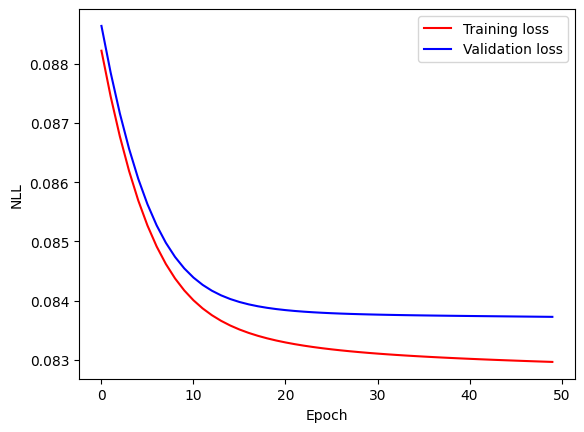

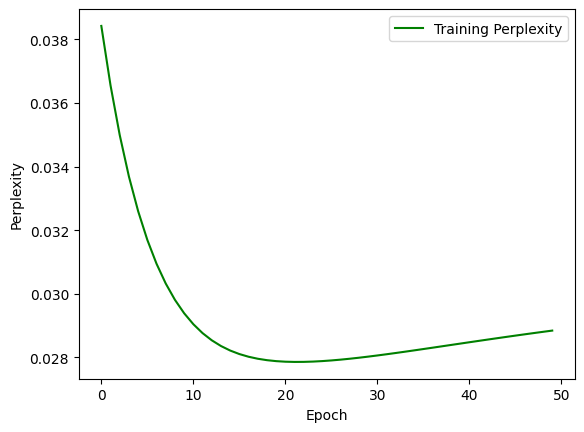

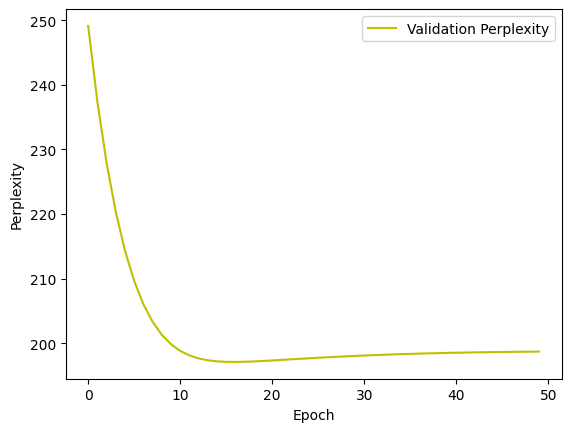

In [ ]:
# Plot training and validation loss
epoch = np.arange(len(training_loss))
plt.figure()
plt.plot(epoch, training_loss, 'r', label='Training loss',)
plt.plot(epoch, validation_loss, 'b', label='Validation loss')
plt.legend()
plt.xlabel('Epoch'), plt.ylabel('NLL')
plt.show()
plt.figure()
plt.plot(epoch, training_perplexity, 'g', label='Training Perplexity',)
plt.legend()
plt.xlabel('Epoch'), plt.ylabel('Perplexity')
plt.show()
plt.figure()
plt.plot(epoch, validation_perplexity, 'y', label='Validation Perplexity')
plt.legend()
plt.xlabel('Epoch'), plt.ylabel('Perplexity')
plt.show()

In [ ]:
from tqdm import tqdm  
# Get first sentence in test set
inputs = tokenizer.encode("what ")
# One-hot encode input and target sequence
inputs_one_hot = one_hot_encode_sequence(inputs, vocab)

# Initialize hidden state as zeros
h = np.zeros((hidden_size, 1))
c = np.zeros((hidden_size, 1))
generated_tokens = []
# Forward pass
for i in tqdm(range(20)):
    z_s, f_s, i_s, g_s, C_s, o_s, h_s, v_s, outputs = forward_lstm(inputs_one_hot, h, c, params)
    out_tokens = [vocab[np.argmax(output)] for output in outputs]
    generated_tokens.extend(out_tokens)
    inputs_one_hot = one_hot_encode_sequence(out_tokens, vocab)



# Print example
print('Input sentence:')
print(tokenizer.decode(inputs))



print('\nPredicted sequence:')
# out_tokens = [vocab[np.argmax(output)] for output in outputs]
print(tokenizer.decode(generated_tokens))

  0%|          | 0/20 [00:00<?, ?it/s]/var/folders/vr/pjldmcbs6clf6d4_jtzr5y1w0000gp/T/ipykernel_43457/1004258910.py:41: DeprecationWarning: `row_stack` alias is deprecated. Use `np.vstack` directly.
  z = np.row_stack((h_prev, x))
100%|██████████| 20/20 [00:00<00:00, 6460.23it/s]

Input sentence:
what 

Predicted sequence:
cccccccccccccccccccccccccccccccccccccccc


In [ ]:
print(tokenizer.decode(generated_tokens))

cccccccccccccccccccccccccccccccccccccccc


In [ ]:
len(vocab)

906